ME5895 - Nonlinear Systems <br /> 
Mohammad Mundiwala <br /> 
Course Project<br /> 
November 25 2024 <br /> 
### **A data driven approach to solve the circular restricted three body problem (CR3BP)**

In [1]:
# Import necessary libraries
import numpy as np
import math
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.animation import FuncAnimation
from matplotlib.collections import LineCollection
from IPython.display import HTML
matplotlib.rcParams['animation.embed_limit'] = 50000000

import mosek  # If you plan to use MOSEK later


In [2]:
def cr3bp(t, state, mu, radius_P1, radius_P2):
    """
    Parameters:
    - state: current state [x, y, z, vx, vy, vz]   
    - mu: Mass ratio
    Returns:
    - derivatives: [vx, vy, vz, ax, ay, az]
    """
    x, y, z, vx, vy, vz = state

    # Distances to the primary bodies
    r1 = np.sqrt((x + mu)**2 + y**2 + z**2)
    r2 = np.sqrt((x - 1 + mu)**2 + y**2 + z**2)
    if r1 <= radius_P1 :
        return [0, 0, 0, 0, 0, 0]
    elif r2 <= radius_P2:
        return [1-mu, 0, 0, 0, 0 ,0]
    # Avoid division by zero
    if r1 == 0 or r2 == 0:
        raise ValueError("Collision detected: r1 or r2 is zero.")

    # Compute the acceleration components
    ax = 2*vy + x - (1 - mu)*(x + mu)/r1**3 - mu*(x - 1 + mu)/r2**3
    ay = -2*vx + y - (1 - mu)*y/r1**3 - mu*y/r2**3
    az = -(1 - mu)*z/r1**3 - mu*z/r2**3

    return [vx, vy, vz, ax, ay, az]


Lets Use the Earth - Moon system as our case for consistency and relatability. imagine we are floating in orbit.. what would actually happen to us? 

In [3]:
# Define parameters
mass_earth = 5.972e24  #kg
mass_moon = 7.348e22   #kg
radius_earth = 6371   #km
radius_moon = 1737    #km
distance_earth_moon  = 384400  #km
radius_earth_norm = radius_earth / distance_earth_moon
radius_moon_norm = radius_moon / distance_earth_moon

mu = mass_moon/ (mass_moon+ mass_earth)


# Earth-Moon  mu ~ 0.01215

# Time span for the integration
t_span = (0, 50)  # From t=0 to t=10 time units
t_eval = np.linspace(t_span[0], t_span[1], 2000)  # Points at which to store the solution


### Simple Plotting of numerical solution

In [4]:
# colors

moon_color = '#c2c5cc'
earth_color = '#1313AB'

In [5]:
def plot_cr3bp_trajectory(solution, mu, P1_radius,P2_radius, title='CR3BP Trajectory'):
    x = solution.y[0]
    y = solution.y[1]
    plt.figure(figsize=(10, 7))
    plt.plot(x, y, label='Trajectory', color = '#FF7F50', alpha = 0.6 )
    # Plot Earth
    plt.scatter(-mu, 0, s=500/(3*P1_radius)*3*P1_radius, color=earth_color, label='Earth')
    # plt.gca().add_patch(earth)
    # Plot Moon
    plt.scatter(1-mu, 0, s= 200/(3*P2_radius)* 3*P2_radius, color=moon_color, label='Moon')

    # arrows :)
                # trying to plot '|' at an angle
                # vx_start, vy_start = solution.y[3][0], solution.y[4][0]
                # angle = math.degrees(math.atan2(vy_start, vx_start))
                # plt.text(x[0], y[0], s='|', fontsize=18, rotation = angle , color='#FF7F50')

    plt.plot(x[0], y[0], marker='s', markersize=4, markeredgewidth=2, color='#FF7F50')
    vx_end, vy_end = solution.y[3][-1], solution.y[4][-1]
    # plot arrow direction for momo
    del_y = max(y) - min(y)
    arrow_scale = 0.02 * del_y
    # arrow_scale = 0.05  # Adjust the scale as needed
    plt.arrow(x[-1], y[-1], vx_end * 0.0001, vy_end * 0.0001, head_width=arrow_scale, head_length=1.3*arrow_scale, fc='#FF7F50', ec='#FF7F50')
    # plt.gca().add_patch(moon)
    plt.xlabel('X', fontsize = 18)
    plt.ylabel('Y', fontsize = 18)
    plt.title(title, fontsize = 20)
    plt.legend(fontsize = 18)
    plt.grid(True, linestyle='--', alpha=0.5, zorder = -1)
    plt.xlim(min(min(x)-0.1, -mu-0.2), max(max(x)+0.1, 1-mu + 0.2))         # These limits are so the figure looks decent for all different trajectory paths and always includes the earth moon wind and fire
    plt.ylim(min(min(y)-0.3, -max(y) -0.3, -0.5), max(max(y) + 0.3, -min(y) +0.3, 0.5))
    # plt.axis('equal')
    plt.show()

Lets take 3 random initial conditions and see how the system responds!

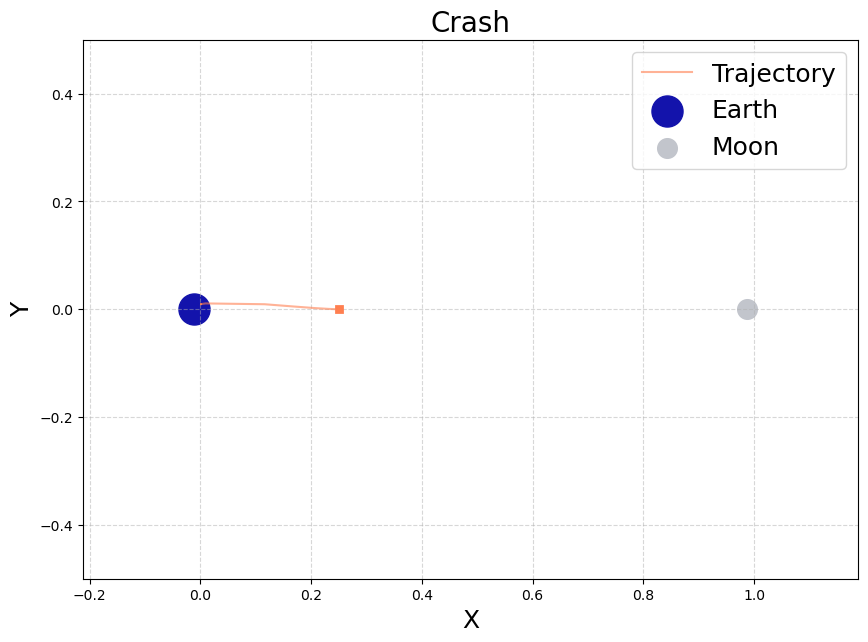

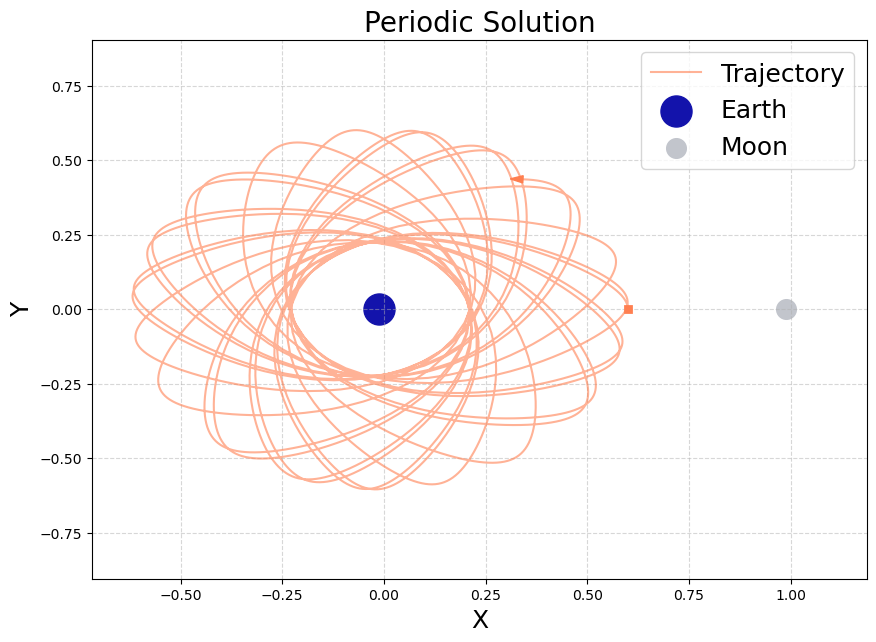

KeyboardInterrupt: 

In [6]:
##### SOLVING The SYSTEM NUMERIALLY USING PRE DEFINED FUNCITONS ABOVE AT 3 RANDOM INITIAL CONDITON
# Initial conditions of the satelliete body - simple
# [x, y, z, vx, vy, vz] 
initial_state = [0.25, 0.0, 0.0, 0.0, 0.0, 0.0] 
solution = solve_ivp(cr3bp, t_span, initial_state, args=(mu, radius_earth_norm, radius_moon_norm), t_eval=t_eval, 
                     method='DOP853', rtol=1e-9, atol=1e-12)
plot_cr3bp_trajectory(solution, mu, P1_radius= radius_earth_norm, P2_radius = radius_moon_norm, title='Crash')

# interesting initial conditions
initial_state_periodic = [0.6, 0.0, 0.0, 0.0, 0.3, 0.0]
solution_periodic = solve_ivp(cr3bp, t_span, initial_state_periodic, args=(mu,radius_earth_norm, radius_moon_norm), 
                              t_eval=t_eval, method='DOP853', rtol=1e-9, atol=1e-12)

plot_cr3bp_trajectory(solution_periodic, mu,  P1_radius= radius_earth_norm, P2_radius= radius_moon_norm, title='Periodic Solution')

# interesting initial conditions
initial_state_moon = [0.6, 0.0, 0.0, 0.0, 0.9, 0.0]
solution_moon = solve_ivp(cr3bp, t_span, initial_state_moon, args=(mu,radius_earth_norm, radius_moon_norm), 
                              t_eval=t_eval, method='DOP853', rtol=1e-9, atol=1e-12)
plot_cr3bp_trajectory(solution_moon, mu,  P1_radius= radius_earth_norm, P2_radius= radius_moon_norm,  title='What the heck')

#Spiral
# interesting initial conditions
initial_state_spiral = [0.02725292, 2.97274708, 0.0, 0.0, 0.0, 0.0]
solution_spiral = solve_ivp(cr3bp, t_span, initial_state_spiral, args=(mu,radius_earth_norm, radius_moon_norm), 
                              t_eval=t_eval, method='DOP853', rtol=1e-9, atol=1e-12)
plot_cr3bp_trajectory(solution_spiral, mu,  P1_radius= radius_earth_norm, P2_radius= radius_moon_norm,  title='Spiral')


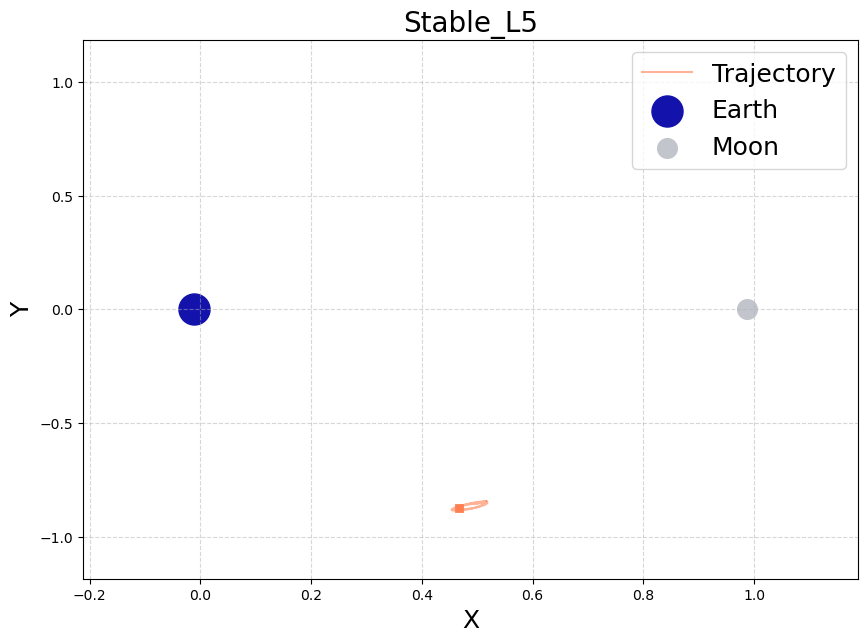

In [7]:
#STABLE
# from stabiltiy anlaysis (0.48785, -0.86603)
initial_state_stable_L5 = [0.46785, -0.87603, 0.0, 0.0, 0, 0]
solution_stable_L5 = solve_ivp(cr3bp, t_span, initial_state_stable_L5, args=(mu,radius_earth_norm, radius_moon_norm), 
                              t_eval=t_eval, method='DOP853', rtol=1e-9, atol=1e-12)
plot_cr3bp_trajectory(solution_stable_L5, mu,  P1_radius= radius_earth_norm, P2_radius= radius_moon_norm,  title='Stable_L5')

# #STABLE
# # from stabiltiy anlaysis (-1.005062, 0
# initial_state_stable_L3 = [-1.005062, 0, 0.0, 0.0, 0.2, -0.1]
# solution_stable_L3 = solve_ivp(cr3bp, t_span, initial_state_stable_L3, args=(mu,radius_earth_norm, radius_moon_norm), 
#                               t_eval=t_eval, method='DOP853', rtol=1e-9, atol=1e-12)
# plot_cr3bp_trajectory(solution_stable_L3, mu,  P1_radius= radius_earth_norm, P2_radius= radius_moon_norm,  title='Stable_L3')

THE ANSWER IS {{ value }}

# Animation of Solution Below oooohhhh ahhhh

In [ ]:

x = solution_stable_L5.y[0].tolist()[::]
y = solution_stable_L5.y[1].tolist()[::]
fig, ax = plt.subplots(figsize=(10, 7))

# Create line segments for the trajectory
segments = [((x[i], y[i]), (x[i+1], y[i+1])) for i in range(len(x)-1)]
lc = LineCollection([], linewidth=2, cmap='autumn')
ax.add_collection(lc)
ax.set_xlim(min(x) - 0.1, max(x) + 0.1)
ax.set_ylim(min(y) - 0.1, max(y) + 0.1)
ax.set_xlabel('X', fontsize = 18)
ax.set_ylabel('Y', fontsize = 18)
ax.set_title('Funky', fontsize = 20)
ax.grid(True, linestyle='--', alpha=0.2)

# Plot Earth and Moon
# earth = plt.Circle((-mu, 0), 3*radius_earth_norm, color='#1313AB', label='Earth')
# moon = plt.Circle((1 - mu, 0), 3*radius_moon_norm, color='#c2c5cc', label='Moon')
# ax.add_patch(earth)
# ax.add_patch(moon)
ax.scatter(-mu, 0,s=500, color='#1313AB' )
ax.scatter(1-mu, 0, s=200, color='#c2c5cc')

# Initialize trajectory line and moving dot
line, = ax.plot([], [], color='#FF7F50', label='Trajectory', alpha = 0.4)
dot, = ax.plot([], [], 'o', color='gold', markersize=8)

def init():
    line.set_data([], [])
    dot.set_data([], [])
    return line, dot

# def update(frame):
#     line.set_data((x[:frame],), (y[:frame],))
#     dot.set_data((x[frame-1],), (y[frame-1],))
#     lc.set_segments(segments[:frame-1])
#     lc.set_alpha(np.linspace(0.1, 1, frame-1))  # Older segments more transparent
#     return line, dot, lc
def update(frame):
    line.set_data((x[:frame],), (y[:frame],))
    dot.set_data((x[frame-1],), (y[frame-1],))
    
    # Update segments up to the current frame
    current_segments = segments[:frame-1]
    lc.set_segments(current_segments)
    
    # Set alpha fading from 0.1 to 1
    alphas = np.linspace(0.1, 1, len(current_segments))
    colors = plt.cm.Reds(alphas)
    lc.set_colors(colors)
    
    return dot, lc

# anim = FuncAnimation(fig, update, frames=len(x), init_func=init, blit=True, interval=20)


anim = FuncAnimation(fig, update, frames=len(x), init_func=init, blit=True, interval=20)
anim.save('cr3bp_trajectory_L5.mp4', writer='ffmpeg', fps=30, dpi=300, bitrate=2000)
# # HTML(anim.to_jshtml())


### Stability analysis

----------------------------------------------------------
# Data Driven Approach - LSTM disaster

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from mpl_toolkits.mplot3d import Axes3D

import os

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# 1. Load the data
# Assuming `solution_periodic` is already in the environment
# If saved to a file, load it appropriately
# For example:
# import pickle
# with open('solution_periodic.pkl', 'rb') as f:
#     solution_periodic = pickle.load(f)

# Extract time and state vectors
t = solution_stable_L5.t  # Shape: (num_time_steps,)
y = solution_stable_L5.y  # Shape: (num_variables, num_time_steps)

print(f"Time array shape: {t.shape}")  # Expected: (num_time_steps,)
print(f"State vectors shape: {y.shape}")  # Expected: (6, num_time_steps)

# Transpose y to shape (num_time_steps, 6)
y = y.T
print(f"Transposed state vectors shape: {y.shape}")  # Expected: (num_time_steps, 6)

# 2. Create input-output pairs
def create_dataset(states, look_back=1):
    X, Y = [], []
    for i in range(len(states) - look_back):
        X.append(states[i:i+look_back])
        Y.append(states[i + look_back])
    return np.array(X), np.array(Y)

look_back = 1
X, Y = create_dataset(y, look_back)

print(f"Input shape: {X.shape}")  # Expected: (num_time_steps - look_back, look_back, 6)
print(f"Output shape: {Y.shape}") # Expected: (num_time_steps - look_back, 6)

# 3. Split the data
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, shuffle=False
)
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

# 4. Normalize the data
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_train_reshaped = X_train.reshape(-1, X_train.shape[2])
X_test_reshaped = X_test.reshape(-1, X_test.shape[2])

scaler_X.fit(X_train_reshaped)
scaler_Y.fit(Y_train)

X_train_scaled = scaler_X.transform(X_train_reshaped).reshape(X_train.shape)
X_test_scaled = scaler_X.transform(X_test_reshaped).reshape(X_test.shape)
Y_train_scaled = scaler_Y.transform(Y_train)
Y_test_scaled = scaler_Y.transform(Y_test)

print("Data normalization complete.")

# 5. Create PyTorch Datasets and DataLoaders
class CR3BP_Dataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

train_dataset = CR3BP_Dataset(X_train_scaled, Y_train_scaled)
test_dataset = CR3BP_Dataset(X_test_scaled, Y_test_scaled)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created.")

# 6. Define the LSTM model
class CR3BP_LSTM(nn.Module):
    def __init__(self, input_size=6, hidden_size=128, num_layers=4, output_size=6, dropout=0.2):
        super(CR3BP_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]  # Last time step
        out = self.fc(out)
        return out

model = CR3BP_LSTM(input_size=6, hidden_size=128, num_layers=2, output_size=6, dropout=0.2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f"Using device: {device}")
print(model)

# 7. Train the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 200
patience = 10
best_val_loss = np.inf
epochs_no_improve = 0

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for X_batch, Y_batch in train_loader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(X_batch)
        loss = criterion(outputs, Y_batch)
        
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item() * X_batch.size(0)
    
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    # Validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for X_batch, Y_batch in test_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            
            outputs = model(X_batch)
            loss = criterion(outputs, Y_batch)
            
            running_val_loss += loss.item() * X_batch.size(0)
    
    epoch_val_loss = running_val_loss / len(test_loader.dataset)
    val_losses.append(epoch_val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {epoch_train_loss:.6f} - "
          f"Val Loss: {epoch_val_loss:.6f}")
    
    # Early stopping
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping!")
            break




Time array shape: (2000,)
State vectors shape: (6, 2000)
Transposed state vectors shape: (2000, 6)
Input shape: (1999, 1, 6)
Output shape: (1999, 6)
Training set size: 1599 samples
Testing set size: 400 samples
Data normalization complete.
DataLoaders created.
Using device: cpu
CR3BP_LSTM(
  (lstm): LSTM(6, 128, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)
Epoch [1/200] - Train Loss: 0.624090 - Val Loss: 0.562813
Epoch [2/200] - Train Loss: 0.360086 - Val Loss: 0.128160
Epoch [3/200] - Train Loss: 0.045353 - Val Loss: 0.029164
Epoch [4/200] - Train Loss: 0.025965 - Val Loss: 0.023486
Epoch [5/200] - Train Loss: 0.024196 - Val Loss: 0.022995
Epoch [6/200] - Train Loss: 0.023504 - Val Loss: 0.022565
Epoch [7/200] - Train Loss: 0.022615 - Val Loss: 0.022187
Epoch [8/200] - Train Loss: 0.021621 - Val Loss: 0.021052
Epoch [9/200] - Train Loss: 0.020134 - Val Loss: 0.020162
Epoch [10/200] - Train Loss: 0.017655 - Val Loss: 0.017914

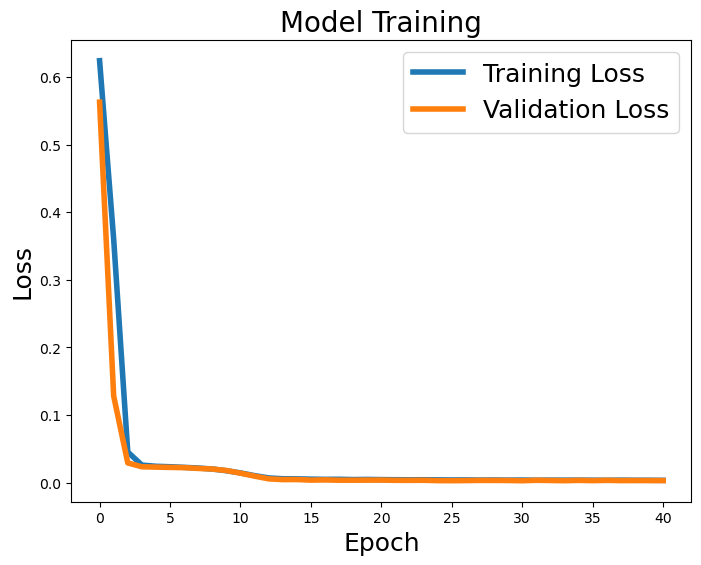

In [17]:
# Plot training and validation loss
plt.figure(figsize=(8,6))
plt.plot(train_losses,  label='Training Loss', linewidth=4)
plt.plot(val_losses, label='Validation Loss', linewidth=4)
plt.title('Model Training', fontsize = 20)
plt.ylabel('Loss', fontsize=18)
plt.xlabel('Epoch',fontsize=18)
plt.legend(fontsize=18)
plt.show()

In [18]:
import torch
import numpy as np

# Define a mock solution class to mimic solve_ivp's output structure
class MockSolution:
    def __init__(self, t, y):
        self.t = t
        self.y = y
        self.success = True
        self.message = 'Data-driven solution'

# Function to simulate trajectory using the trained model
def simulate_trajectory(initial_state, model, scaler_X, scaler_Y, steps=5000, look_back=1):
    model.eval()
    trajectory = [initial_state]
    current_state = initial_state.copy()
    
    for _ in range(steps):
        # Normalize the current state
        input_scaled = scaler_X.transform(np.array(current_state).reshape(1, -1))
        input_scaled = input_scaled.reshape(1, look_back, -1)
        input_tensor = torch.tensor(input_scaled, dtype=torch.float32).to(device)
        
        # Predict the next state
        with torch.no_grad():
            next_state_scaled = model(input_tensor).cpu().numpy()
        next_state = scaler_Y.inverse_transform(next_state_scaled).flatten()
        
        # Append the predicted state to the trajectory
        trajectory.append(next_state)
        current_state = next_state
    
    # Convert trajectory to numpy array and transpose to match plotting function
    trajectory = np.array(trajectory).T  # Shape: (6, steps+1)
    
    # Create time array (assuming uniform time steps)
    t_start = solution_periodic.t[0]
    t_end = solution_periodic.t[-1]
    t_steps = np.linspace(t_start, t_end, steps+1)
    
    # Create a mock solution object
    solution_data_driven = MockSolution(t_steps, trajectory)
    
    return solution_data_driven

# Choose an initial state from the numerical solution
initial_state_L5 = solution_stable_L5.y[:, 0]  # Shape: (6,)

# Simulate the data-driven trajectory
solution_data_driven = simulate_trajectory(
    initial_state=initial_state_L5,
    model=model,
    scaler_X=scaler_X,
    scaler_Y=scaler_Y,
    steps=200000,          # Adjust the number of steps as needed
    look_back=1          # Should match the look_back used during training
)


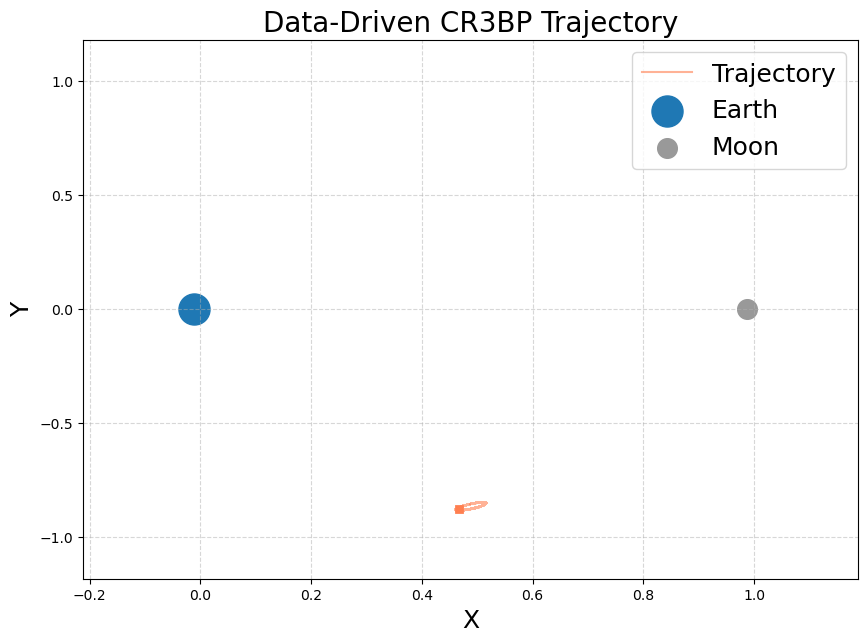

In [19]:
# Define colors for Earth and Moon
earth_color = '#1f78b4'  # Blue
moon_color = '#999999'   # Gray

# Plot the data-driven trajectory
plot_cr3bp_trajectory(
    solution=solution_data_driven,
    mu=mu,
    P1_radius=radius_earth_norm,
    P2_radius=radius_moon_norm,
    title='Data-Driven CR3BP Trajectory'
)


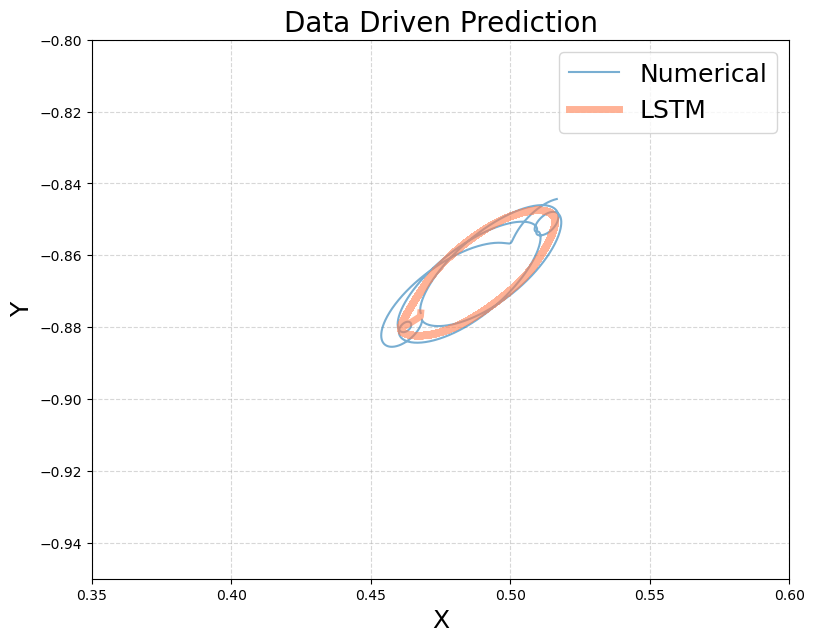

In [20]:
import matplotlib.pyplot as plt

def plot_comparison(numerical_solution, data_driven_solution, mu, P1_radius, P2_radius):
    plt.figure(figsize=(9, 7))
    
    # Plot numerical trajectory
    x_num, y_num, z_num = numerical_solution.y[0], numerical_solution.y[1], numerical_solution.y[2]
    plt.plot(x_num, y_num, label='Numerical', color='#1f78b4', alpha=0.6)
    
    # Plot data-driven trajectory
    x_driven, y_driven, z_driven = data_driven_solution.y[0], data_driven_solution.y[1], data_driven_solution.y[2]
    plt.plot(x_driven, y_driven, label='LSTM', color='#FF7F50', linewidth = 5, alpha=0.6)
    
    # Plot Earth
    plt.scatter(-mu, 0, s=500/(3*P1_radius)*3*P1_radius, color=earth_color)
    
    # Plot Moon
    plt.scatter(1-mu, 0, s=200/(3*P2_radius)*3*P2_radius, color=moon_color)
    
    plt.xlabel('X', fontsize=18)
    plt.ylabel('Y', fontsize=18)
    plt.title('Data Driven Prediction', fontsize=20)
    plt.legend(fontsize=18)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xlim(min(min(x_num)-0.1, -mu-0.2), max(max(x_num)+0.1, 1-mu + 0.2))
    plt.xlim(0.35, 0.6)
    plt.ylim(min(min(y_num)-0.3, -max(y_num) -0.3, -0.5), max(max(y_num) + 0.3, -min(y_num) +0.3, 0.5))
    plt.ylim(-.95, -.8)
    plt.show()

# Plot comparison
plot_comparison(
    numerical_solution=solution_stable_L5,
    data_driven_solution=solution_data_driven,
    mu=mu,
    P1_radius=radius_earth_norm,
    P2_radius=radius_moon_norm
)
